In [1]:
%load_ext memory_profiler
%load_ext line_profiler

# timer grabbed from https://stackoverflow.com/questions/7370801/measure-time-elapsed-in-python
from timeit import default_timer as timer
class benchmark(object):
    def __init__(self, msg, fmt="%0.3g"):
        self.msg = msg
        self.fmt = fmt

    def __enter__(self):
        self.start = timer()
        return self

    def __exit__(self, *args):
        t = timer() - self.start
        print(("%s: " + self.fmt + " seconds") % (self.msg, t))
        self.time = t

# Problem

In this assignment you will implement one or more algorithms for the traveling salesman problem, such as the dynamic programming algorithm covered in the video lectures.
Here is a data file describing a TSP instance.
- tsp.txt

The first line indicates the number of cities.
Each city is a point in the plane, and each subsequent line indicates the x- and y-coordinates of a single city.

The distance between two cities is defined as the Euclidean distance --- that is, two cities at locations $(x,y)$ and $(z,w)$ have distance $\sqrt{(x - z)^2 + (y - w)^2}$ between them.

In the box below, type in the minimum cost of a traveling salesman tour for this instance, rounded down to the nearest integer.

OPTIONAL: If you want bigger data sets to play with, check out the TSP instances from around the world [here](http://www.math.uwaterloo.ca/tsp/world/countries.html).
The smallest data set (Western Sahara) has 29 cities, and most of the data sets are much bigger than that.
What's the largest of these data sets that you're able to solve --- using dynamic programming or, if you like, a completely different method?

HINT: You might experiment with ways to reduce the data set size.
For example, trying plotting the points.
Can you infer any structure of the optimal solution?
Can you use that structure to speed up your algorithm?

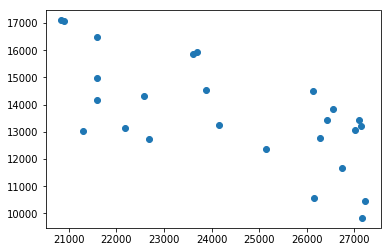

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_cities(filename):
    ncities = 0
    X, Y = [], []
    for n, line in enumerate(open(filename)):
        if n == 0:
            ncities = int(line[0])
        else:
            x, y = map(float, line.split())
            X.append(x)
            Y.append(y)
    
    plt.scatter(X, Y)
    plt.show()
    
    return ncities, X, Y

n, X, Y = plot_cities("tsp.txt")

# [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem): A Dynamic Programming Solution

## Subproblems

For every destination $j \in \{1, 2, \dots, n\}$, every subset $S \subseteq \{1, 2, \dots, n\}$ that contains $1$ and $j$, let $L_{S,j}$ be the minimum length of a path from $1$ to $j$ that visits precisely the vertices of $S$ (exactly once each).

## Optimal substructure

Let $P$ be a shortest path from $1$ to $j$ that visits the vertices $S$ (assume $|S| \geq 2$) (exactly once each).
If the last hop of $P$ is $(k,j)$, then $P'$ is a shortest path from $1$ to $k$ that visits every vertex of $S - \{j\}$ exactly once.
\begin{align}
  L_{S,j} = \min_{k \in S, k \neq j} \{L_{S-\{j\}, k} + c_{kj}\}
\end{align}

## Algorithm

Denote the whole set of city labels as $G = \{1, 2, \dots, n\}$.

Let $A[S, j]$ be a 2-D array, indexed by subsets $S \subseteq G$ that contain $1$ and destinations $j \in \{1, 2, \dots, n\}$

Base case: $A[S, 1] = \begin{cases} 0 &\text{if }S = \{1\} \\ +\infty &\text{otherwise} \end{cases}$
```python
for m in range(2, n + 1):
    for S of size m that contains 1:
        for j in S and j != 1:
            A[S, j] = min([A[S without j, k] + c[k, j] for k in S if k != j])
return min([A[G, j] + c[j, 1] for j in range(2, n + 1)])
```

Running time: ${\cal O}(n^2 2^n)$

In [3]:
import numpy as np
import math, itertools, fractions
from tqdm import tqdm

DEBUG = 3
def read_file(filename):
    ncities = 0
    coord = []
    for n, line in enumerate(open(filename)):
        if n == 0:
            ncities = int(line)
        else:
            x, y = map(float, line.split())
            coord.append((x, y))
    
    if DEBUG > 2:
        print "Number of cities: {0}".format(ncities)
        print "Label    {0:>22}".format("Coordinates")
        for i, xy in enumerate(coord):
            x, y = xy
            print "{0:>5d}    {1:10.4f}, {2:10.4f}".format(i, x, y)
        print
    return ncities, coord

def compute_dist(coord_list):
    """ Compute the Euclidean distance.
    coord_list -- a list of city coordinates
    
    Return: a numpy 2D array of distances
    """
    
    n = len(coord_list)
    out = np.zeros((n, n))
    for i in range(n):
        x1, y1 = coord_list[i]
        for j in range(i + 1, n):
            x2, y2 = coord_list[j]
            dist = math.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )
            out[i][j] = dist
            out[j][i] = dist
    
    if DEBUG > 2:
        print "==> Distance Matrix <==\n"
        print out, "\n"
    return out

def nCk(n, k):
    """ Return the combination number of n choose k.
    Taken from https://stackoverflow.com/questions/3025162/statistics-combinations-in-python.
    """
    return int( reduce(lambda x, y: x * y, (fractions.Fraction(n - i, i + 1) for i in range(k)), 1) )

def compute_key(S):
    """ Compute key value of a given subset of cities.
    S -- a list of city labels
    
    Return: the key value of S -- sum_{i}^{S} 2^i
    
    Cities are represented by a bit string.
    For example, S = {1, 3, 4, 5} and the total number of cities is 10,
    then the key of S is
    city label: 9 8 7 6 5 4 3 2 1 0
    bit string: 0 0 0 0 1 1 1 0 1 0 = 2^5 + 2^4 + 2^3 + 2^1
    """
    return reduce(lambda x, y: x + 2 ** y, S, 0)

def tsp_dp(ncities, coord):
    """ Compute traveling salesman problem.
    ncities -- number of cities
    coord -- coordinates of the cities
    
    Return: the shortest distance of TSP
    
    To save some memory, the float type to set to single precision.
    """
    
    # pairwise distance matrix
    Dmat = compute_dist(coord)
    
    # base case
    A0 = np.full((ncities, ncities), np.inf, dtype=np.float32)
    A0[0] = 0
    I0 = {} # index map
    for i in range(ncities):
        I0[2 ** i] = i
    
    if DEBUG > 2:
        print "==> Base Case <==\n"
        nS = A0.shape[0]
        print "Matrix A (nS:{0} by ncities:{1})".format(nS, ncities)
        print A0, "\n"
        print "Index Map"
        print I0, "\n"
    
    # the starting city is labeled as 0
    for m in range(1, ncities):
        A = np.full((nCk(ncities - 1, m), ncities), np.inf, dtype=np.float32)
        I = {}
#         for iS, S in enumerate( itertools.combinations(range(1, ncities), m) ):
        for iS, S in enumerate( tqdm(itertools.combinations(range(1, ncities), m),
                                     desc='m = {:>2} of {}'.format(m, ncities - 1)) ):
            S = np.fromiter(S, np.uint8)
            S = np.append(S, 0)
            S_key = compute_key(S) # recomputing S_key is computationally light
            I[S_key] = iS
            
            for nj, j in enumerate(S):
                if j == 0:
                    continue
                
                S0_key = S_key - 2 ** j
                iS0 = I0[S0_key]
                
                temp = A0[iS0][j]
                A0[iS0][j] = np.inf
                A[iS][j] = np.min(A0[iS0, S] + Dmat[j, S])
                A0[iS0][j] = temp
#                 Sk = S[S != j]
#                 A[iS][j] = np.min(A0[iS0, Sk] + Dmat[j, Sk])
        
        A0 = np.copy(A)
        I0 = I
        
        if DEBUG > 2:
            nS = A0.shape[0]
            print "==> m = {0} <==\n".format(m)
            print "Matrix A (nS:{0} by ncities:{1})".format(nS, ncities)
            print A0, "\n"
            print "Index Map"
            print I0, "\n"
    
    if DEBUG > 1:
        print "==> Final Iteration (m = {0}) <==\n".format(ncities - 1)
        nS = A0.shape[0]
        print "Matrix A (nS:{0} by ncities:{1})".format(nS, ncities)
        print A0, "\n"
    
    return np.min(A0[0] + Dmat[0])

In [4]:
def run_tsp_dp(filename):
    with benchmark("TSP_DP on ".format(filename)) as r:
        ncities, coord = read_file(filename)
        vmin = tsp_dp(ncities, coord)
    return int(vmin)

In [5]:
DEBUG = 3
# %lprun -f tsp_dp run_tsp_dp("test.txt")
%memit vmin = run_tsp_dp("test.txt")
assert vmin == 9, "TSP_DP does not pass the test case test.txt!"
print "TSP_DP passes the test case test.txt!"

m =  1 of 4: 4it [00:00, 4464.40it/s]
m =  2 of 4: 6it [00:00, 8621.39it/s]
m =  3 of 4: 4it [00:00, 3509.14it/s]
m =  4 of 4: 1it [00:00, 1408.43it/s]

Number of cities: 5
Label               Coordinates
    0        2.6512,     3.0900
    1        3.2633,     0.4107
    2        2.7083,     0.3224
    3        1.9880,     4.9078
    4        2.5722,     2.6969

==> Distance Matrix <==

[[ 0.          2.74829056  2.76815885  1.93503048  0.40093136]
 [ 2.74829056  0.          0.56197807  4.67442512  2.38833479]
 [ 2.76815885  0.56197807  0.          4.64164029  2.37838086]
 [ 1.93503048  4.67442512  4.64164029  0.          2.28681421]
 [ 0.40093136  2.38833479  2.37838086  2.28681421  0.        ]] 

==> Base Case <==

Matrix A (nS:5 by ncities:5)
[[  0.   0.   0.   0.   0.]
 [ inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf]] 

Index Map
{8: 3, 1: 0, 2: 1, 4: 2, 16: 4} 

==> m = 1 <==

Matrix A (nS:4 by ncities:5)
[[        inf  2.74829054         inf         inf         inf]
 [        inf         inf  2.76815891         inf         inf]
 [        inf         inf         inf  


m =  1 of 4: 4it [00:00, 5434.80it/s]
m =  2 of 4: 6it [00:00, 4246.68it/s]
m =  3 of 4: 4it [00:00, 4644.85it/s]
m =  4 of 4: 1it [00:00, 1930.19it/s]

Number of cities: 5
Label               Coordinates
    0        2.6512,     3.0900
    1        3.2633,     0.4107
    2        2.7083,     0.3224
    3        1.9880,     4.9078
    4        2.5722,     2.6969

==> Distance Matrix <==

[[ 0.          2.74829056  2.76815885  1.93503048  0.40093136]
 [ 2.74829056  0.          0.56197807  4.67442512  2.38833479]
 [ 2.76815885  0.56197807  0.          4.64164029  2.37838086]
 [ 1.93503048  4.67442512  4.64164029  0.          2.28681421]
 [ 0.40093136  2.38833479  2.37838086  2.28681421  0.        ]] 

==> Base Case <==

Matrix A (nS:5 by ncities:5)
[[  0.   0.   0.   0.   0.]
 [ inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf]] 

Index Map
{8: 3, 1: 0, 2: 1, 4: 2, 16: 4} 

==> m = 1 <==

Matrix A (nS:4 by ncities:5)
[[        inf  2.74829054         inf         inf         inf]
 [        inf         inf  2.76815891         inf         inf]
 [        inf         inf         inf  

In [6]:
DEBUG = 0
# %lprun -f tsp_dp run_tsp_dp("test1.txt")
%memit vmin = run_tsp_dp("test1.txt")
assert vmin == 63, "TSP_DP does not pass the test case test1.txt!"
print "TSP_DP passes the test case test1.txt!"

m =  1 of 17: 17it [00:00, 17874.95it/s]
m =  2 of 17: 136it [00:00, 12386.28it/s]
m =  3 of 17: 680it [00:00, 14246.46it/s]
m =  4 of 17: 2380it [00:00, 14053.49it/s]
m =  5 of 17: 6188it [00:00, 11667.11it/s]
m =  6 of 17: 12376it [00:01, 9268.68it/s]
m =  7 of 17: 19448it [00:02, 9573.18it/s]
m =  8 of 17: 24310it [00:02, 8410.03it/s]
m =  9 of 17: 24310it [00:03, 7804.29it/s]
m = 10 of 17: 19448it [00:02, 6931.77it/s]
m = 11 of 17: 12376it [00:01, 6594.84it/s]
m = 12 of 17: 6188it [00:01, 5961.38it/s]
m = 13 of 17: 2380it [00:00, 5599.60it/s]
m = 14 of 17: 680it [00:00, 5155.38it/s]
m = 15 of 17: 136it [00:00, 4131.48it/s]
m = 16 of 17: 17it [00:00, 2757.49it/s]
m = 17 of 17: 1it [00:00, 878.76it/s]


TSP_DP on : 16.5 seconds
peak memory: 91.18 MiB, increment: 17.27 MiB
TSP_DP passes the test case test1.txt!


In [7]:
DEBUG = 0
%memit vmin = run_tsp_dp("tsp.txt")

m =  1 of 24: 24it [00:00, 12157.40it/s]
m =  2 of 24: 276it [00:00, 14392.99it/s]
m =  3 of 24: 2024it [00:00, 16275.44it/s]
m =  4 of 24: 10626it [00:00, 14438.97it/s]
m =  5 of 24: 42504it [00:03, 12346.11it/s]
m =  6 of 24: 134596it [00:12, 10891.39it/s]
m =  7 of 24: 346104it [00:36, 9383.50it/s]
m =  8 of 24: 735471it [01:26, 8462.22it/s]
m =  9 of 24: 1307504it [02:50, 7681.57it/s]
m = 10 of 24: 1961256it [04:40, 6990.13it/s]
m = 11 of 24: 2496144it [06:18, 6590.52it/s]
m = 12 of 24: 2704156it [07:22, 6117.58it/s]
m = 13 of 24: 2496144it [07:26, 5591.56it/s]
m = 14 of 24: 1961256it [06:23, 5120.15it/s]
m = 15 of 24: 1307504it [04:31, 4824.56it/s]
m = 16 of 24: 735471it [02:41, 4545.88it/s]
m = 17 of 24: 346104it [01:21, 4268.54it/s]
m = 18 of 24: 134596it [00:32, 4096.23it/s]
m = 19 of 24: 42504it [00:10, 3914.37it/s]
m = 20 of 24: 10626it [00:02, 3733.19it/s]
m = 21 of 24: 2024it [00:00, 3605.50it/s]
m = 22 of 24: 276it [00:00, 2902.24it/s]
m = 23 of 24: 24it [00:00, 2640.00it/

TSP_DP on : 2.81e+03 seconds
peak memory: 1314.88 MiB, increment: 1225.34 MiB


In [8]:
# print vmin